In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
tf.config.run_functions_eagerly(True)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' #esta linea salva vidas
tf.config.experimental_run_functions_eagerly(False)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [2]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/Users/Miguel/Desktop/Fotos para IA/Reptiles/Cocodrilo vs Aligator',
    labels='inferred',
    label_mode="binary",#probar a poner binario 
    class_names=['Cocodrilo', 'Alligator'],
    color_mode='rgb',
    batch_size=None, #Se especificara mas adelante
    image_size=(224,224), #Redimension de imagenes
    shuffle=True,  #Baraja las imagenes
    seed=123,#Semilla estatica
    validation_split=0.15,
    subset="training",

)

Found 3661 files belonging to 2 classes.
Using 3112 files for training.


In [3]:
ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/Users/Miguel/Desktop/Fotos para IA/Reptiles/Cocodrilo vs Aligator',
    labels='inferred',
    label_mode="binary",
    class_names=['Cocodrilo', 'Alligator'],
    color_mode='rgb',
    batch_size=None, #Se especificara mas adelante
    image_size=(224,224), #Para redimensionar las imagenes
    shuffle=True,  #Baraja las imagenes
    seed=123,#Semilla estatica
    validation_split=0.15,
    subset="validation",


)

Found 3661 files belonging to 2 classes.
Using 549 files for validation.


In [4]:
#IMAGENES Y LABELS TRAIN
X=[]
Y=[]
for i,(img,label) in enumerate(ds_train):
  #img=cv2.resize(img.numpy(),(tamano_img, tamano_img)) ya hemmos redimensionado
  #img=img.reshape(tamano_img, tamano_img,3)
  X.append(img/255)#dividimos entre 255 para normalizar o se va todo a la mierda
  Y.append(label)

In [5]:
#IMAGENES Y LABELS TEST
Xtest=[]
Ytest=[]
for i,(img,label) in enumerate(ds_validation):
  #img=cv2.resize(img.numpy(),(tamano_img, tamano_img)) ya hemmos redimensionado
  #img=img.reshape(tamano_img, tamano_img,3)
  Xtest.append(img/255)#dividimos entre 255 para normalizar o se va todo a la mierda
  Ytest.append(label)

In [6]:
#FUNCION PARA COMPROBAR SI LAS IMAGENES SON COMPATIBLES CON TENSORFLOW
from pathlib import Path
import imghdr
contador=0
data_dir = "C:/Users/Miguel/Desktop/Fotos para IA/Reptiles/Cocodrilo vs Aligator"
image_extensions = [".png", ".jpg",".jpeg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            contador+=1
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            contador+=1
            os.remove(filepath)
            
print(f"Numero de fotos eliminados: {contador}")

Numero de fotos eliminados: 0


In [7]:
X=np.array(X)
Xtest=np.array(Xtest)
X[0]
Y=np.array(Y)
Ytest=np.array(Ytest)


In [ ]:
#PEQUEÑAS COMPROBACIONES
print(Y.shape)
print(X.shape)

In [8]:
#CREAMOS NUESTRO MODIFICADOR DE IMAGENES
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.01, #ojito con el shear range
    zoom_range=[0.6,1.2],
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8,1.2]



)
data_gen_entrenamiento=datagen.flow(X,Y,batch_size=32)
data_gen_test=datagen.flow(Xtest,Ytest,batch_size=32)
#Le pasamos las imagenes y labels de entrenamiento
#Si algo falla aseurarse de tener las listas como np.array

# MODELO 1 

In [ ]:
#TRANSFER LEARNING
#usamos ResNet50 que tiene 50 capas y esta entrenada con imageNet

base_model=tf.keras.applications.resnet50.ResNet50(
    include_top=False,#para que elimina las capas flatten finales
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
)
#congelamos capas
for layer in base_model.layers[:-2]:
    layer.trainable=False


In [ ]:
#conexion para transfer learning
#nos enganchamos a la ultima capa
x = base_model.layers[-2].output
#añadimos capas para fine tuning
x = tf.keras.layers.Flatten(name='cflatten')(x)

x = tf.keras.layers.Dense(128,activation='relu',name='cD1')(x)
#x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(128,activation='relu',name='cD2')(x)
#x = tf.keras.layers.Dropout(0.3)(x)

output= tf.keras.layers.Dense(2,activation='softmax',name='output')(x)
#ponemos la input layer del modelo y el resto con el fine tunning
new_model = tf.keras.models.Model(base_model.inputs, output)

In [ ]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics="accuracy")

In [ ]:
tensorboard=tf.keras.callbacks.TensorBoard(log_dir='logs/modelo.9')
new_model.fit(
    data_gen_entrenamiento,
    epochs=3,
    batch_size=34,
    validation_data=data_gen_test,
    steps_per_epoch=int(np.ceil(len(X)/float(32))),
    #steps_per_epoch = total_samples / batch_size
    validation_steps=int(np.ceil(len(Xtest)/float(32))),
    #validation_steps = np.ceil(numero_total_muestras_validacion / tamano_lote_validacion).astype(int)
    callbacks=[tensorboard]
)

In [ ]:
#HACEMOS UN TEST
test_loss = new_model.evaluate(Xtest, Ytest)
print(f"Test loss is: {test_loss}")

In [ ]:
new_model.save('Cocodrilo_vs_Alligator_70.h5')
from IPython import display
from ipywidgets import FileUpload

display.FileLink('Cocodrilo_vs_Alligator_70.h5')
display.display(display.FileLink('Cocodrilo_vs_Alligator_70.h5', result_html_prefix="Haz clic aquí para descargar: "))

In [ ]:
%load_ext tensorboard

# Lanzamiento de TensorBoard
%tensorboard --logdir logs/modelo.7

# MODELO 2

In [9]:
#TRANSFER LEARNING
#usamos MobileNet que tiene 50 capas y esta entrenada con imageNet

base_model=tf.keras.applications.mobilenet.MobileNet(
    include_top=False,#para que elimina las capas flatten finales
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
)


In [10]:
#conexion para transfer learning
#nos enganchamos a la ultima capa
x = base_model.layers[-1].output
#añadimos capas para fine tuning
x = tf.keras.layers.Flatten(name='cflatten')(x)

x = tf.keras.layers.Dense(128,activation='relu',name='cD1')(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(128,activation='relu',name='cD2')(x)
x = tf.keras.layers.Dropout(0.3)(x)

output= tf.keras.layers.Dense(2,activation='softmax',name='output')(x) #usalmos softmax ya que las clases estan relaccionadas
#ponemos la input layer del modelo y el resto con el fine tunning
new_model = tf.keras.models.Model(base_model.inputs, output)

In [11]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics="accuracy")

In [12]:
#tensorboard=tf.keras.callbacks.TensorBoard(log_dir='logs/modelo.5')
history=new_model.fit(
    data_gen_entrenamiento,
    epochs=10,batch_size=16,
    validation_data=data_gen_test,
    steps_per_epoch=int(np.ceil(len(X)/float(32))),
    #steps_per_epoch = total_samples / batch_size
    validation_steps=int(np.ceil(len(Xtest)/float(32))),
    #validation_steps = np.ceil(numero_total_muestras_validacion / tamano_lote_validacion).astype(int)
    #callbacks=[tensorboard]
)

Epoch 1/10
98/98 [==============================] - 48s 427ms/step - loss: 0.7883 - accuracy: 0.7147 - val_loss: 0.6905 - val_accuracy: 0.8871
Epoch 2/10
98/98 [==============================] - 41s 417ms/step - loss: 0.6972 - accuracy: 0.9299 - val_loss: 0.6901 - val_accuracy: 0.9927
Epoch 3/10
98/98 [==============================] - 41s 418ms/step - loss: 0.6944 - accuracy: 0.9862 - val_loss: 0.6906 - val_accuracy: 0.9964
Epoch 4/10
98/98 [==============================] - 41s 421ms/step - loss: 0.6941 - accuracy: 0.9868 - val_loss: 0.6893 - val_accuracy: 1.0000
Epoch 5/10
98/98 [==============================] - 41s 417ms/step - loss: 0.6933 - accuracy: 0.9897 - val_loss: 0.6923 - val_accuracy: 0.9617
Epoch 6/10
98/98 [==============================] - 41s 416ms/step - loss: 0.6928 - accuracy: 0.9749 - val_loss: 0.6974 - val_accuracy: 0.9982
Epoch 7/10
98/98 [==============================] - 41s 417ms/step - loss: 0.6933 - accuracy: 0.9785 - val_loss: 0.6919 - val_accuracy: 0.9818

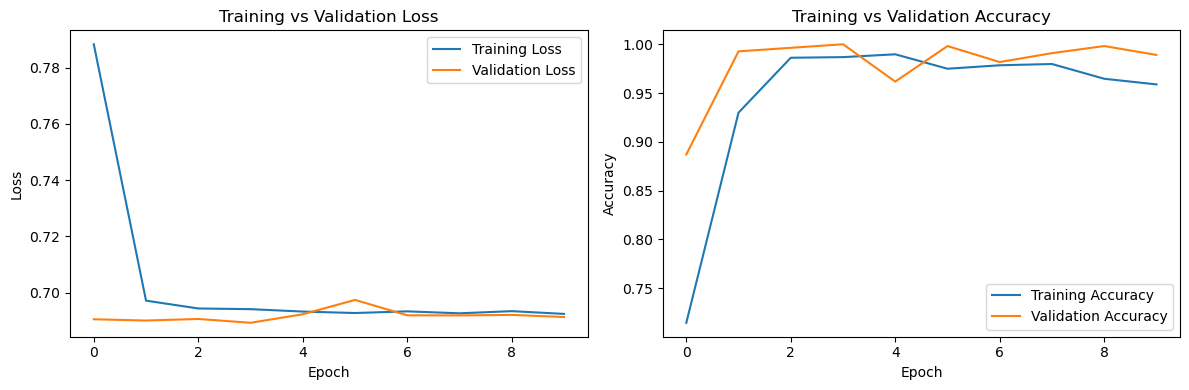

In [13]:
# Extraer la información de la pérdida y la precisión de los historiales
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Graficar la pérdida durante el entrenamiento y la validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

# Graficar la precisión durante el entrenamiento y la validación
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Ajustar el diseño de los gráficos y mostrarlos
plt.tight_layout()
plt.show()

In [14]:
#HACEMOS UN TEST
test_loss = new_model.evaluate(Xtest, Ytest)
print(f"Test loss is: {test_loss}")

18/18 [==============================] - 1s 24ms/step - loss: 0.6912 - accuracy: 0.9872
Test loss is: [0.6911954879760742, 0.9872495532035828]


In [15]:
new_model.save('Cocodrilo_vs_Alligator_98.h5')
from IPython import display
from ipywidgets import FileUpload

display.FileLink('Cocodrilo_vs_Alligator_98.h5')
display.display(display.FileLink('Cocodrilo_vs_Alligator_98.h5', result_html_prefix="Haz clic aquí para descargar: "))

C:\Users\Miguel\Cocodrilo_vs_Alligator_98.h5